#**Homework 8 - Sequence-to-sequence**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# Sequence-to-Sequence 介紹
- 大多數常見的 **sequence-to-sequence (seq2seq) model** 為 **encoder-decoder model**，主要由兩個部分組成，分別是 **Encoder** 和 **Decoder**，而這兩個部分則大多使用 **recurrent neural network (RNN)** 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
- **Encoder** 是將**一連串**的輸入，如文字、影片、聲音訊號等，編碼為**單個向量**，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
- **Decoder** 是將 Encoder 輸出的單個向量逐步解碼，**一次輸出一個結果**，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束


![seq2seq](https://i.imgur.com/0zeDyuI.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g.		tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 		湯姆 是 個 學生 。）

- TODO
  - Teachering Forcing 的功用: 嘗試不用 Teachering Forcing 做訓練
  - 實作 Attention Mechanism
  - 實作 Beam Search
  - 實作 Schedule Sampling

# 下載和引入需要的 libraries

In [0]:
%%capture
!pip3 install --user nltk

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision
from torchvision import datasets, transforms

import numpy as np
import sys
import os
import random
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 判斷是用 CPU 還是 GPU 執行運算


# 資料結構

## 定義資料的轉換
- 將不同長度的答案拓展到相同長度，以便訓練模型

In [0]:
import numpy as np

class LabelTransform(object):
  def __init__(self, size, pad):
    self.size = size
    self.pad = pad

  def __call__(self, label):
    label = np.pad(label, (0, (self.size - label.shape[0])), mode='constant', constant_values=self.pad)
    return label


In [0]:
import re
import json
import pickle

class EN2CNDataset(data.Dataset):
  def __init__(self, root, max_output_len, set_name):
    self.root = root
    self.max_output_len = max_output_len
    self.word2int, self.int2word = self.get_dictionary()

    # 載入資料
    self.data = []
    with open(os.path.join(self.root, f'{set_name}'), "rb") as f:
      self.data=pickle.load(f)
    print (f'{set_name} dataset size: {len(self.data)}')

    self.vocab_size = len(self.word2int)

    self.transform = LabelTransform(max_output_len, self.word2int['<PAD>'])

  def get_dictionary(self):
    # 載入字典
    with open(os.path.join(self.root, f'vocab_word2int.json'), "r") as f:
      word2int = json.load(f)
    with open(os.path.join(self.root, f'vocab_int2word.json'), "r") as f:
      int2word = json.load(f)
    return word2int, int2word

  def __len__(self):
    return len(self.data)

  def __getitem__(self, Index, pad=False):
    global device
    sentence = self.data[Index]
    sentence_idx = []
    for word in sentence:
        if (word in self.word2int.keys()):
            sentence_idx.append(self.word2int[word])
        else:#如果遇到不会的单词就赋给不知道
            sentence_idx.append(self.word2int["<UNK>"])
    if pad:
        sentence_idx = np.asarray(sentence_idx)
        sentence_idx = self.transform(sentence_idx)

    sentence_idx = torch.LongTensor(sentence_idx).to(device)
    target = sentence_idx.clone()
    return sentence_idx, target


# 模型架構

## Encoder
- seq2seq模型的編碼器為RNN。 對於每個輸入，，**Encoder** 會輸出**一個向量**和**一個隱藏狀態(hidden state)**，並將隱藏狀態用於下一個輸入，換句話說，**Encoder** 會逐步讀取輸入序列，並輸出單個矢量（最終隱藏狀態）
- 參數:
  - en_vocab_size 是英文字典的大小，也就是英文的 subword 的個數
  - emb_dim 是 embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用，可以使用預先訓練好的 word embedding，如 Glove 和 word2vector
  - hid_dim 是 RNN 輸出和隱藏狀態的維度
  - n_layers 是 RNN 要疊多少層
  - dropout 是決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
- Encoder 的輸入和輸出:
  - 輸入: 
    - 英文的整數序列 e.g. 1, 28, 29, 205, 2
  - 輸出: 
    - outputs: 最上層 RNN 全部的輸出，可以用 Attention 再進行處理
    - hidden: 每層最後的隱藏狀態，將傳遞到 Decoder 進行解碼


In [0]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, emb_dim)
    self.hid_dim = hid_dim
    self.n_layers = n_layers
    self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input):
    # input = [batch size, sequence len]
    embedding = self.embedding(input)
    outputs, hidden = self.rnn(self.dropout(embedding))
    # outputs = [batch size, sequence len, hid dim * directions]
    # hidden =  [num_layers * directions, batch size  , hid dim]
    # outputs 是最上層RNN的輸出
        
    return outputs, hidden


## Decoder
- **Decoder** 是另一個 RNN，在最簡單的 seq2seq decoder 中，僅使用 **Encoder** 每一層最後的隱藏狀態來進行解碼，而這最後的隱藏狀態有時被稱為 “content vector”，因為可以想像它對整個前文序列進行編碼， 此 “content vector” 用作 **Decoder** 的**初始**隱藏狀態， 而 **Encoder** 的輸出通常用於 Attention Mechanism
- 參數
  - en_vocab_size 是英文字典的大小，也就是英文的 subword 的個數
  - emb_dim 是 embedding 的維度，是用來將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用，可以使用預先訓練好的 word embedding，如 Glove 和 word2vector
  - hid_dim 是 RNN 輸出和隱藏狀態的維度
  - output_dim 是最終輸出的維度，一般來說是將 hid_dim 轉到 one-hot vector 的單詞向量
  - n_layers 是 RNN 要疊多少層
  - dropout 是決定有多少的機率會將某個節點變為0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不用
  - isatt 是來決定是否使用 Attention Mechanism

- Decoder 的輸入和輸出:
  - 輸入:
    - 前一次解碼出來的單詞的整數表示
  - 輸出:
    - hidden: 根據輸入和前一次的隱藏狀態，現在的隱藏狀態更新的結果
    - output: 每個字有多少機率是這次解碼的結果

In [0]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, emb_dim, hid_dim, n_layers, dropout, isatt):
    super().__init__()
    self.vocab_size = vocab_size
    self.hid_dim = hid_dim * 2
    self.n_layers = n_layers
    self.embedding = nn.Embedding(vocab_size, config.emb_dim)
    self.isatt = isatt
    self.attention = Attention(hid_dim)
    # 如果使用 Attention Mechanism 會使得輸入維度變化，請在這裡修改
    # e.g. Attention 接在輸入後面會使得維度變化，所以輸入維度改為
    # self.input_dim = emb_dim + hid_dim * 2 if isatt else emb_dim
    self.input_dim = emb_dim
    self.rnn = nn.GRU(self.input_dim, self.hid_dim, self.n_layers, dropout = dropout, batch_first=True)
    self.embedding2vocab1 = nn.Linear(self.hid_dim, self.hid_dim * 2)
    self.embedding2vocab2 = nn.Linear(self.hid_dim * 2, self.hid_dim * 4)
    self.embedding2vocab3 = nn.Linear(self.hid_dim * 4, self.vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, encoder_outputs):
    # input = [batch size, vocab size]
    # hidden = [batch size, n layers * directions, hid dim]
    # Decoder 只會是單向，所以 directions=1
    input = input.unsqueeze(1)
    embedded = self.dropout(self.embedding(input))
    # embedded = [batch size, 1, emb dim]
    if self.isatt:
      attn = self.attention(encoder_outputs, hidden)
      # TODO: 在這裡決定如何使用 Attention，e.g. 相加 或是 接在後面， 請注意維度變化
    output, hidden = self.rnn(embedded, hidden)
    # output = [batch size, 1, hid dim]
    # hidden = [num_layers, batch size, hid dim]

    # 將 RNN 的輸出轉為每個詞出現的機率
    output = self.embedding2vocab1(output.squeeze(1))
    output = self.embedding2vocab2(output)
    prediction = self.embedding2vocab3(output)
    # prediction = [batch size, vocab size]
    return prediction, hidden



## Attention
- 當輸入過長，或是單獨靠 “content vector” 無法取得整個輸入的意思時，用 Attention Mechanism 來提供 **Decoder** 更多的資訊
- 主要是根據現在 **Decoder hidden state** ，去計算在 **Encoder outputs** 中，那些與其有較高的關係，根據關系的數值來決定該傳給 **Decoder** 那些額外資訊 
- 常見 Attention 的實作是用 Neural Network / Dot Product 來算 **Decoder hidden state** 和 **Encoder outputs** 之間的關係，再對所有算出來的數值做 **softmax** ，最後根據過完 **softmax** 的值對 **Encoder outputs** 做 **weight sum**

- TODO:
實作 Attention Mechanism

In [0]:
class Attention(nn.Module):
  def __init__(self, hid_dim):
    super(Attention, self).__init__()
    self.hid_dim = hid_dim
  
  def forward(self, encoder_outputs, decoder_hidden):
    # encoder_outputs = [batch size, sequence len, hid dim * directions]
    # decoder_hidden = [num_layers, batch size, hid dim]
    # 一般來說是取 Encoder 最後一層的 hidden state 來做 attention
    ########
    # TODO #
    ########
    attention=None
    
    return attention
    

## Seq2Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- 不斷地將 **Decoder** 的輸出傳回 **Decoder** ，進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [0]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
    assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
            
  def forward(self, input, target, teacher_forcing_ratio):
    # input  = [batch size, input len]
    # target = [batch size, target len]
    # teacher_forcing_ratio 是有多少機率使用正確答案來訓練
    batch_size = target.shape[0]
    target_len = target.shape[1]
    vocab_size = self.decoder.vocab_size

    # 準備一個儲存空間來儲存輸出
    outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
    # 將輸入放入 Encoder
    encoder_outputs, hidden = self.encoder(input)
    # Encoder 最後的隱藏層(hidden state) 用來初始化 Decoder
    # encoder_outputs 主要是使用在 Attention
    # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
    # hidden =  [num_layers * directions, batch size  , hid dim]  --> [num_layers, directions, batch size  , hid dim]
    hidden = hidden.view(self.encoder.n_layers, 2, batch_size, -1)
    hidden = torch.cat((hidden[:, -2, :, :], hidden[:, -1, :, :]), dim=2)
    # 取的 <BOS> token
    input = target[:, 0]
    preds = []
    for t in range(1, target_len):
      output, hidden = self.decoder(input, hidden, encoder_outputs)
      outputs[:, t] = output
      # 決定是否用正確答案來做訓練
      teacher_force = random.random() <= teacher_forcing_ratio
      # 取出機率最大的單詞
      top1 = output.argmax(1)
      # 如果是 teacher force 則用正解訓練，反之用自己預測的單詞做預測
      input = target[:, t] if teacher_force and t < target_len else top1
      preds.append(top1.unsqueeze(1))
    preds = torch.cat(preds, 1)
    return outputs, preds

  def inference(self, input, target):
    ########
    # TODO #
    ########
    # 在這裡實施 Beam Search
    # 此函式的 batch size = 1  
    # input  = [batch size, input len]
    # target = [batch size, target len]
    batch_size = input.shape[0]
    input_len = input.shape[1]        # 取得最大字數
    vocab_size = self.decoder.vocab_size

    # 準備一個儲存空間來儲存輸出
    outputs = torch.zeros(batch_size, input_len, vocab_size).to(self.device)
    # 將輸入放入 Encoder
    encoder_outputs, hidden = self.encoder(input)
    # Encoder 最後的隱藏層(hidden state) 用來初始化 Decoder
    # encoder_outputs 主要是使用在 Attention
    # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
    # hidden =  [num_layers * directions, batch size  , hid dim]  --> [num_layers, directions, batch size  , hid dim]
    hidden = hidden.view(self.encoder.n_layers, 2, batch_size, -1)
    hidden = torch.cat((hidden[:, -2, :, :], hidden[:, -1, :, :]), dim=2)
    # 取的 <BOS> token
    input = target[:, 0]
    preds = []
    for t in range(1, input_len):
      output, hidden = self.decoder(input, hidden, encoder_outputs)
      # 將預測結果存起來
      outputs[:, t] = output
      # 取出機率最大的單詞
      top1 = output.argmax(1)
      input = top1
      preds.append(top1.unsqueeze(1))
    preds = torch.cat(preds, 1)
    return outputs, preds


# utils
- 基本操作:
  - 儲存模型
  - 載入模型
  - 建構模型
  - 將一連串的數字還原回句子
  - 計算 BLEU score
  - 迭代 dataloader
  

## 儲存模型

In [0]:
def save_model(model, optimizer, store_model_path, step):
  torch.save(model.state_dict(), f'{store_model_path}/model_{step}.ckpt')
  return

## 載入模型

In [0]:
def load_model(model, load_model_path):
  print(f'Load model from {load_model_path}')
  model.load_state_dict(torch.load(f'{load_model_path}.ckpt'))
  return model

## 建構模型

In [0]:
def build_model(config, vocab_size):
  # 建構模型
  encoder = Encoder(vocab_size, config.emb_dim, config.hid_dim, config.n_layers, config.dropout)
  decoder = Decoder(vocab_size, config.emb_dim, config.hid_dim, config.n_layers, config.dropout, config.attention)
  model = Seq2Seq(encoder, decoder, device)
  print(model)
  # 建構 optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
  print(optimizer)
  if config.load_model:
    model = load_model(model, config.load_model_path)
  model = model.to(device)

  return model, optimizer


## 數字轉句子

In [0]:
def tokens2sentence(outputs, int2word):
  sentences = []
  for tokens in outputs:
    sentence = []
    for token in tokens:
      word = int2word[str(int(token))]
      if word == '<EOS>':
        break
      sentence.append(word)
    sentences.append(sentence)
  
  return sentences


## 計算 BLEU score

In [0]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def computebleu(sentences, targets):
  score = 0 
  assert (len(sentences) == len(targets))

  def cut_token(sentence):
    tmp = []
    for token in sentence:
      if token == '<UNK>' or token.isdigit() or len(bytes(token[0], encoding='utf-8')) == 1:
        tmp.append(token)
      else:
        tmp += [word for word in token]
    return tmp 

  for sentence, target in zip(sentences, targets):
    sentence = cut_token(sentence)
    target = cut_token(target)
    score += sentence_bleu([target], sentence, weights=(1, 0, 0, 0))                                                                                          
  
  return score


##迭代 dataloader

In [0]:
def infinite_iter(data_loader):
  it = iter(data_loader)
  while True:
    try:
      ret = next(it)
      yield ret
    except StopIteration:
      it = iter(data_loader)

## schedule_sampling

In [0]:
########
# TODO #
########

# 請在這裡直接 return 0 來取消 Teacher Forcing
# 請在這裡實作 schedule_sampling 的策略

def schedule_sampling(step,summary_steps):
    return 1-0.8*step/summary_steps

# 訓練步驟

## 訓練
- 訓練階段

In [0]:
def train(model, optimizer, train_iter, loss_function, total_steps, summary_steps, train_dataset):
  model.train()
  model.zero_grad()
  losses = []
  loss_sum = 0.0
  for step in range(summary_steps):
    sources, targets = next(train_iter)
    sources, targets = sources.to(device), targets.to(device)
    outputs, preds = model(sources, targets, schedule_sampling(step,summary_steps))
    # targets 的第一個 token 是 <BOS> 所以忽略
    outputs = outputs[:, 1:].reshape(-1, outputs.size(2))
    targets = targets[:, 1:].reshape(-1)
    loss = loss_function(outputs, targets)
    
    optimizer.zero_grad()
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    loss_sum += loss.item()
    if (step + 1) % 5 == 0:
      loss_sum = loss_sum / 5
      print ("\r", "train [{}] loss: {:.3f}, Perplexity: {:.3f}      ".format(total_steps + step + 1, loss_sum, np.exp(loss_sum)), end=" ")
      losses.append(loss_sum)
      loss_sum = 0.0

  return model, optimizer, losses


## 檢驗/測試
- 防止訓練發生overfitting

In [0]:
def test(model, dataloader, loss_function):
  model.eval()
  loss_sum, bleu_score= 0.0, 0.0
  n = 0
  result = []
  for sources, targets in dataloader:
    sources, targets = sources.to(device), targets.to(device)
    batch_size = sources.size(0)
    outputs, preds = model.inference(sources, targets)
    # targets 的第一個 token 是 <BOS> 所以忽略
    outputs = outputs[:, 1:].reshape(-1, outputs.size(2))
    targets = targets[:, 1:].reshape(-1)

    loss = loss_function(outputs, targets)
    loss_sum += loss.item()

    # 將預測結果轉為文字
    targets = targets.view(sources.size(0), -1)
    preds = tokens2sentence(preds, dataloader.dataset.int2word)
    sources = tokens2sentence(sources, dataloader.dataset.int2word)
    targets = tokens2sentence(targets, dataloader.dataset.int2word)
    for source, pred, target in zip(sources, preds, targets):
      result.append((pred, target))
    # 計算 Bleu Score
    bleu_score += computebleu(preds, targets)

    n += batch_size

  return loss_sum / len(dataloader), bleu_score / n, result


## 訓練流程
- 先訓練，再檢驗

In [0]:
def train_process(config):
  # 準備訓練資料
  train_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data')
  train_loader = data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
  train_iter = infinite_iter(train_loader)
  # 準備檢驗資料
  val_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data')
  val_loader = data.DataLoader(val_dataset, batch_size=1)
  # 建構模型
  model, optimizer = build_model(config, train_dataset.vocab_size)
  loss_function = nn.CrossEntropyLoss(ignore_index=0)

  train_losses, val_losses, bleu_scores = [], [], []
  total_steps = 0
  while (total_steps < config.num_steps):
    # 訓練模型
    model, optimizer, loss = train(model, optimizer, train_iter, loss_function, total_steps, config.summary_steps, train_dataset)
    train_losses += loss
    # 檢驗模型
    val_loss, bleu_score, result = test(model, val_loader, loss_function)
    val_losses.append(val_loss)
    bleu_scores.append(bleu_score)

    total_steps += config.summary_steps
    print ("\r", "val [{}] loss: {:.3f}, Perplexity: {:.3f}, blue score: {:.3f}       ".format(total_steps, val_loss, np.exp(val_loss), bleu_score))
    
    # 儲存模型和結果
    if total_steps % config.store_steps == 0 or total_steps >= config.num_steps:
      save_model(model, optimizer, config.store_model_path, total_steps)
      with open(f'{config.store_model_path}/output_{total_steps}.txt', 'w') as f:
        for line in result:
          print (line, file=f)
    
  return train_losses, val_losses, bleu_scores


## 測試流程

In [0]:
def test_process(config):
  # 準備測試資料
  test_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'rhythm_pattern_list_all.data')
  test_loader = data.DataLoader(test_dataset, batch_size=1)
  # 建構模型
  model, optimizer = build_model(config, test_dataset.vocab_size)
  print ("Finish build model")
  loss_function = nn.CrossEntropyLoss(ignore_index=0)
  model.eval()
  # 測試模型
  test_loss, bleu_score, result = test(model, test_loader, loss_function)
  # 儲存結果
  with open(f'{config.store_model_path}/test_output.txt', 'w') as f:
    for line in result:
      print (line, file=f)

  return test_loss, bleu_score


# Config
- 實驗的參數設定表

In [0]:
class configurations(object):
  def __init__(self):
    self.batch_size = 1
    self.emb_dim = 256
    self.hid_dim = 512
    self.n_layers = 3
    self.dropout = 0.5
    self.learning_rate = 0.00005
    self.max_output_len = 50              # 最後輸出句子的最大長度
    self.num_steps = 12000                # 總訓練次數
    self.store_steps = 2000                # 訓練多少次後須儲存模型
    self.summary_steps = 300              # 訓練多少次後須檢驗是否有overfitting
    self.load_model = True               # 是否需載入模型
    self.store_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_baseline"      # 儲存模型的位置
    self.load_model_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_baseline/model_"+str(self.num_steps)           # 載入模型的位置 e.g. "./ckpt/model_{step}" 
    self.data_path = "/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_folder/"          # 資料存放的位置
    self.attention = False                # 是否使用 Attention Mechanism


#Main Function
- 讀入參數
- 進行訓練或是推論

## train

In [0]:
if __name__ == '__main__':
  config = configurations()
  print ('config:\n', vars(config))
  train_losses, val_losses, bleu_scores = train_process(config)


config:
 {'batch_size': 1, 'emb_dim': 256, 'hid_dim': 512, 'n_layers': 3, 'dropout': 0.5, 'learning_rate': 5e-05, 'max_output_len': 50, 'num_steps': 12000, 'store_steps': 2000, 'summary_steps': 300, 'load_model': False, 'store_model_path': '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_baseline', 'load_model_path': '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_baseline/model_12000', 'data_path': '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_folder/', 'attention': False}
rhythm_pattern_list_all.data dataset size: 1032
rhythm_pattern_list_all.data dataset size: 1032
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(467, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(467, 256)
    (attention): Attention()
    (rnn): GRU(256, 1024, num_layers=3, batch_first

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


 val [300] loss: 4.047, Perplexity: 57.241, blue score: 0.236       
 val [600] loss: 2.973, Perplexity: 19.559, blue score: 0.304       
 val [900] loss: 2.859, Perplexity: 17.442, blue score: 0.326       
 val [1200] loss: 2.894, Perplexity: 18.068, blue score: 0.299       
 val [1500] loss: 2.955, Perplexity: 19.198, blue score: 0.345       
 val [1800] loss: 2.810, Perplexity: 16.602, blue score: 0.324       
 val [2100] loss: 2.736, Perplexity: 15.432, blue score: 0.330       
 val [2400] loss: 2.754, Perplexity: 15.706, blue score: 0.333       
 val [2700] loss: 2.728, Perplexity: 15.299, blue score: 0.369       
 val [3000] loss: 2.515, Perplexity: 12.369, blue score: 0.378       
 val [3300] loss: 2.430, Perplexity: 11.364, blue score: 0.402       
 val [3600] loss: 2.418, Perplexity: 11.226, blue score: 0.420       
 val [3900] loss: 2.406, Perplexity: 11.094, blue score: 0.401       
 val [4200] loss: 2.453, Perplexity: 11.625, blue score: 0.392       
 val [4500] loss: 2.235

## test

In [0]:
# 在執行 Test 之前，請先行至 config 設定所要載入的模型位置
if __name__ == '__main__':
  config = configurations()
  print ('config:\n', vars(config))
  test_loss, bleu_score = test_process(config)
  print (f'test loss: {test_loss}, bleu_score: {bleu_score}')

config:
 {'batch_size': 1, 'emb_dim': 256, 'hid_dim': 512, 'n_layers': 3, 'dropout': 0.5, 'learning_rate': 5e-05, 'max_output_len': 50, 'num_steps': 12000, 'store_steps': 2000, 'summary_steps': 300, 'load_model': True, 'store_model_path': '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_baseline', 'load_model_path': '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_seq2seq_baseline/model_12000', 'data_path': '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/data_folder/', 'attention': False}
rhythm_pattern_list_all.data dataset size: 1032
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(467, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(467, 256)
    (attention): Attention()
    (rnn): GRU(256, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (embedding2vocab1): Linea

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


test loss: 1.6380730646684072, bleu_score: 0.6236905419846795


# 圖形化訓練過程

## 以圖表呈現 訓練 的 loss 變化趨勢

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0, flags=flags)


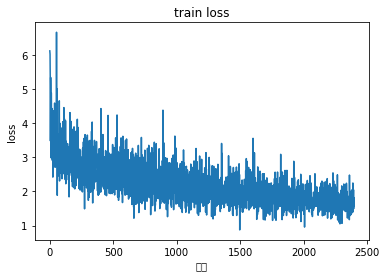

In [0]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses)
plt.xlabel('次數')
plt.ylabel('loss')
plt.title('train loss')
plt.show()

## 以圖表呈現 檢驗 的 loss 變化趨勢

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0, flags=flags)


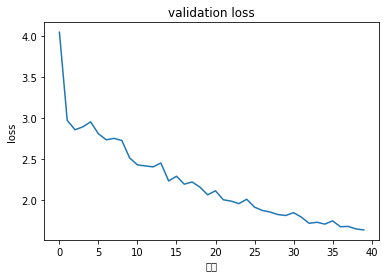

In [0]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(val_losses)
plt.xlabel('次數')
plt.ylabel('loss')
plt.title('validation loss')
plt.show()

## BLEU score

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0, flags=flags)


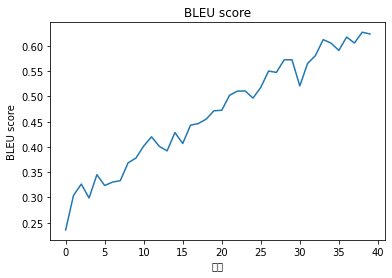

In [0]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(bleu_scores)
plt.xlabel('次數')
plt.ylabel('BLEU score')
plt.title('BLEU score')
plt.show()